In [90]:
import requests
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Resumen
El proyecto explora la calidad del aire en diversas regiones utilizando datos de la API WAQI. Analiza factores como contaminantes clave (PM2.5, PM10, CO, SO2, NO2, O3), identifica tendencias temporales y geográficas, y plantea modelos predictivos para evaluar riesgos a la salud. Los hallazgos ofrecen insights para estrategias de mitigación en áreas afectadas.

# Objetivo
Determinar las regiones con mayor exposición a contaminantes atmosféricos, analizar patrones temporales de la calidad del aire y proporcionar recomendaciones para la toma de decisiones en políticas públicas ambientales.

# Contexto Comercial
Se plantea un escenario ficticio donde una organización sin fines de lucro, "Green Futures", busca priorizar esfuerzos de mitigación ambiental. Esta ONG requiere información clara y precisa sobre la calidad del aire para establecer programas en regiones más afectadas y prevenir riesgos a la salud pública.

# Motivación: 
La contaminación del aire es un problema crítico que afecta la salud pública y el medio ambiente. Utilizando modelos de Machine Learning, podemos predecir la calidad del aire y tomar decisiones informadas para mitigar sus efectos.

# Audiencia: 
Este análisis está dirigido a organizaciones como "Green Futures", gobiernos locales y empresas que buscan implementar políticas y tecnologías para mejorar la calidad del aire 

# Problema Principal: 
Predecir el AQI (Índice de Calidad del Aire) en función de los niveles de contaminantes (PM2.5, PM10, CO, etc.).

# Hipotesis
La calidad del aire empeora en las regiones urbanas durante los meses de invierno debido a la acumulación de contaminantes y condiciones climáticas

In [6]:
# Token y URL base
API_TOKEN = '8805f353b60369a1d81814e80dc9296e74b01171'
BASE_URL = 'http://api.waqi.info/feed'

# Ciudades elegidas
cities = ['Lima', 'Bogota', 'Santiago', 'Buenos Aires', 'Mexico City']
data = []

# Solicitudes a la API
for city in cities:
    response = requests.get(f"{BASE_URL}/{city}/?token={API_TOKEN}")
    if response.status_code == 200:
        json_data = response.json()
        if json_data['status'] == 'ok':
            city_data = json_data['data']
            # Datos relevantes.
            data.append({
                'city': city,
                'aqi': city_data['aqi'],
                'dominant_pollutant': city_data['dominentpol'],
                **{k: v['v'] for k, v in city_data['iaqi'].items()}
            })

df = pd.DataFrame(data)
print(df.head())


           city aqi dominant_pollutant     co     h   no2    o3       p  pm10  \
0          Lima  99               pm25  392.9  78.5   8.8   1.4   985.1    48   
1        Bogota  21               pm25    2.5  45.0   2.0   9.1  1027.0    16   
2      Santiago  80               pm25    1.7  25.0   9.8  33.6  1012.0    64   
3  Buenos Aires   -                       2.8  37.1   6.9   NaN  1003.6    13   
4   Mexico City  78               pm25   12.3  41.0  35.2   2.4  1029.1    50   

   pm25   so2     t   wg  dew    r    w     wd  
0  99.0  11.5  25.8  0.5  NaN  NaN  NaN    NaN  
1  21.0   NaN  20.1  8.2  9.0  0.6  1.8  121.0  
2  80.0   NaN  31.0  NaN  9.0  NaN  3.6    NaN  
3   NaN   NaN  36.6  1.4  NaN  NaN  0.1    NaN  
4  78.0  15.8  16.0  NaN  3.0  NaN  2.0    NaN  


In [7]:
# Información general del DataFrame
print(df.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                5 non-null      object 
 1   aqi                 5 non-null      object 
 2   dominant_pollutant  5 non-null      object 
 3   co                  5 non-null      float64
 4   h                   5 non-null      float64
 5   no2                 5 non-null      float64
 6   o3                  4 non-null      float64
 7   p                   5 non-null      float64
 8   pm10                5 non-null      int64  
 9   pm25                4 non-null      float64
 10  so2                 2 non-null      float64
 11  t                   5 non-null      float64
 12  wg                  3 non-null      float64
 13  dew                 3 non-null      float64
 14  r                   1 non-null      float64
 15  w                   4 non-null      float64
 16  wd          

In [8]:
print(df.describe())  # Resumen estadístico


               co          h        no2         o3            p       pm10  \
count    5.000000   5.000000   5.000000   4.000000     5.000000   5.000000   
mean    82.440000  45.320000  12.540000  11.625000  1011.360000  38.200000   
std    173.606532  20.000925  13.017988  15.043576    18.093728  22.521101   
min      1.700000  25.000000   2.000000   1.400000   985.100000  13.000000   
25%      2.500000  37.100000   6.900000   2.150000  1003.600000  16.000000   
50%      2.800000  41.000000   8.800000   5.750000  1012.000000  48.000000   
75%     12.300000  45.000000   9.800000  15.225000  1027.000000  50.000000   
max    392.900000  78.500000  35.200000  33.600000  1029.100000  64.000000   

            pm25        so2          t        wg       dew    r         w  \
count   4.000000   2.000000   5.000000  3.000000  3.000000  1.0  4.000000   
mean   69.500000  13.650000  25.900000  3.366667  7.000000  0.6  1.875000   
std    33.689761   3.040559   8.248636  4.209909  3.464102  NaN  1

In [9]:
# Resumen del DataFrame
print("Resumen del DataFrame:")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")
print("\nTipos de variables:")
print(df.dtypes)
print("\nResumen estadístico:")
print(df.describe())

Resumen del DataFrame:
Número de filas: 5
Número de columnas: 17

Tipos de variables:
city                   object
aqi                    object
dominant_pollutant     object
co                    float64
h                     float64
no2                   float64
o3                    float64
p                     float64
pm10                    int64
pm25                  float64
so2                   float64
t                     float64
wg                    float64
dew                   float64
r                     float64
w                     float64
wd                    float64
dtype: object

Resumen estadístico:
               co          h        no2         o3            p       pm10  \
count    5.000000   5.000000   5.000000   4.000000     5.000000   5.000000   
mean    82.440000  45.320000  12.540000  11.625000  1011.360000  38.200000   
std    173.606532  20.000925  13.017988  15.043576    18.093728  22.521101   
min      1.700000  25.000000   2.000000   1.400000   985

In [10]:
print(df.isnull().sum())  # Conteo de valores nulos en cada columna

city                  0
aqi                   0
dominant_pollutant    0
co                    0
h                     0
no2                   0
o3                    1
p                     0
pm10                  0
pm25                  1
so2                   3
t                     0
wg                    2
dew                   2
r                     4
w                     1
wd                    4
dtype: int64


In [11]:
# Rellenamos lo valores nulos con la media para una mayor calidad de datos
numeric_cols = df.select_dtypes(include=['number'])
df[numeric_cols.columns] = df[numeric_cols.columns].fillna(numeric_cols.mean())

In [12]:
# Verificamos nuevamente si hay valores nulos.
print(df.isnull().sum())

city                  0
aqi                   0
dominant_pollutant    0
co                    0
h                     0
no2                   0
o3                    0
p                     0
pm10                  0
pm25                  0
so2                   0
t                     0
wg                    0
dew                   0
r                     0
w                     0
wd                    0
dtype: int64


In [13]:
print(df.duplicated().sum())  # Conteo de filas duplicadas

0


In [14]:
#Eliminar duplicados:
df.drop_duplicates(inplace=True)

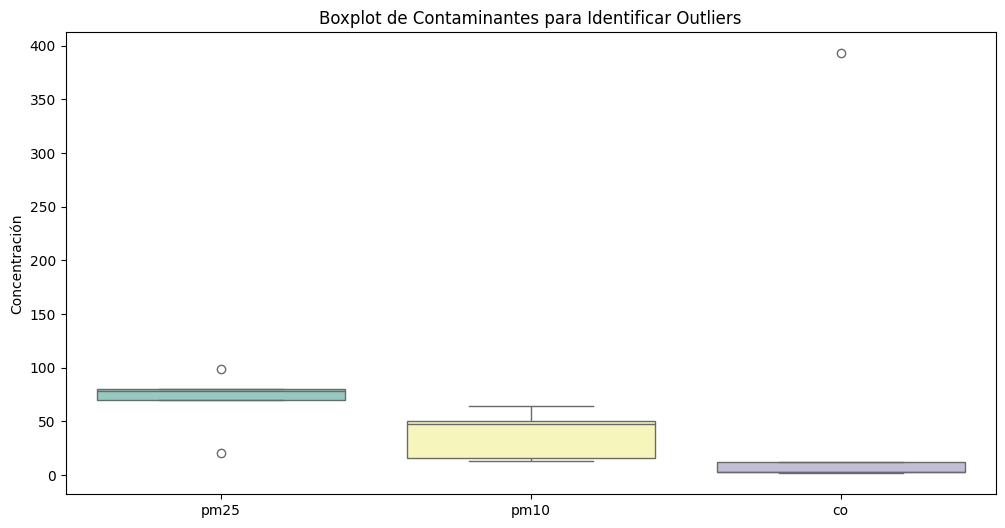

In [15]:
# Visualización de outliers usando boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['aqi', 'pm25', 'pm10', 'co']], palette='Set3')
plt.title('Boxplot de Contaminantes para Identificar Outliers')
plt.ylabel('Concentración')
plt.show()

Seleccionamos las variables más relevantes para predecir comportamientos. Vamos a identificar las columnas con mayor correlación con el AQI (índice de calidad del aire).

In [16]:
# Verificar los tipos de datos de todas las columnas
print("Tipos de datos de las columnas:")
print(df.dtypes)

Tipos de datos de las columnas:
city                   object
aqi                    object
dominant_pollutant     object
co                    float64
h                     float64
no2                   float64
o3                    float64
p                     float64
pm10                    int64
pm25                  float64
so2                   float64
t                     float64
wg                    float64
dew                   float64
r                     float64
w                     float64
wd                    float64
dtype: object


In [17]:
# Convertir la columna 'aqi' a numérico
df['aqi'] = pd.to_numeric(df['aqi'], errors='coerce')  # 'coerce' convierte valores no numéricos a NaN
print("Tipo de dato de la columna 'aqi' después de la conversión:", df['aqi'].dtype)

Tipo de dato de la columna 'aqi' después de la conversión: float64


In [18]:
# Seleccionar solo columnas numéricas
df_numeric = df.select_dtypes(include=['float64', 'int64'])
print("Columnas numéricas en el DataFrame:")
print(df_numeric.columns)

Columnas numéricas en el DataFrame:
Index(['aqi', 'co', 'h', 'no2', 'o3', 'p', 'pm10', 'pm25', 'so2', 't', 'wg',
       'dew', 'r', 'w', 'wd'],
      dtype='object')


In [19]:
# Calcular la correlación de cada variable con el AQI
correlation_with_aqi = df_numeric.corr()['aqi'].sort_values(ascending=False)
print("Correlación de las variables con el AQI:")
print(correlation_with_aqi)

Correlación de las variables con el AQI:
aqi     1.000000
pm25    1.000000
pm10    0.847048
co      0.591921
no2     0.383099
t       0.373749
h       0.327609
w       0.263024
o3     -0.017659
so2    -0.254475
dew    -0.384794
p      -0.671061
wg     -0.988016
r            NaN
wd           NaN
Name: aqi, dtype: float64


In [20]:
# Seleccionamos las variables con mayor correlación (por ejemplo, |correlación| > 0.3)
high_value_features = correlation_with_aqi[abs(correlation_with_aqi) > 0.3].index.tolist()
print("\nFeatures de alto valor para predecir el AQI:", high_value_features)


Features de alto valor para predecir el AQI: ['aqi', 'pm25', 'pm10', 'co', 'no2', 't', 'h', 'dew', 'p', 'wg']


Preguntas a responder por medio de los graficos

1. ¿Qué contaminantes tienen mayor influencia en el AQI?
2. ¿Cómo varía la calidad del aire entre las ciudades seleccionadas?
3. ¿Existen correlaciones significativas entre contaminantes?
4. ¿Cómo se distribuyen las concentraciones de contaminantes clave (PM2.5, PM10, CO)?
5. ¿Cuáles son las regiones más críticas en términos de contaminación?

1. ¿Qué contaminantes tienen mayor influencia en el AQI?


In [21]:
# Calcular la correlación de cada variable con el AQI
correlation_with_aqi = df_numeric.corr()['aqi'].sort_values(ascending=False)

# Filtrar solo los contaminantes (excluyendo 'aqi' y otras columnas no relevantes)
contaminants_correlation = correlation_with_aqi.drop('aqi')  # Excluimos el AQI de la lista

# Mostrar los contaminantes con mayor influencia en el AQI
print("Correlación de los contaminantes con el AQI:")
print(contaminants_correlation)

# Identificar los contaminantes con mayor influencia (por ejemplo, |correlación| > 0.5)
high_influence_contaminants = contaminants_correlation[abs(contaminants_correlation) > 0.5]
print("\nContaminantes con mayor influencia en el AQI (|correlación| > 0.5):")
print(high_influence_contaminants)

Correlación de los contaminantes con el AQI:
pm25    1.000000
pm10    0.847048
co      0.591921
no2     0.383099
t       0.373749
h       0.327609
w       0.263024
o3     -0.017659
so2    -0.254475
dew    -0.384794
p      -0.671061
wg     -0.988016
r            NaN
wd           NaN
Name: aqi, dtype: float64

Contaminantes con mayor influencia en el AQI (|correlación| > 0.5):
pm25    1.000000
pm10    0.847048
co      0.591921
p      -0.671061
wg     -0.988016
Name: aqi, dtype: float64


C:\Users\jherv\AppData\Local\Temp\ipykernel_26128\830498288.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contaminants_correlation.index, y=contaminants_correlation.values, palette='viridis')


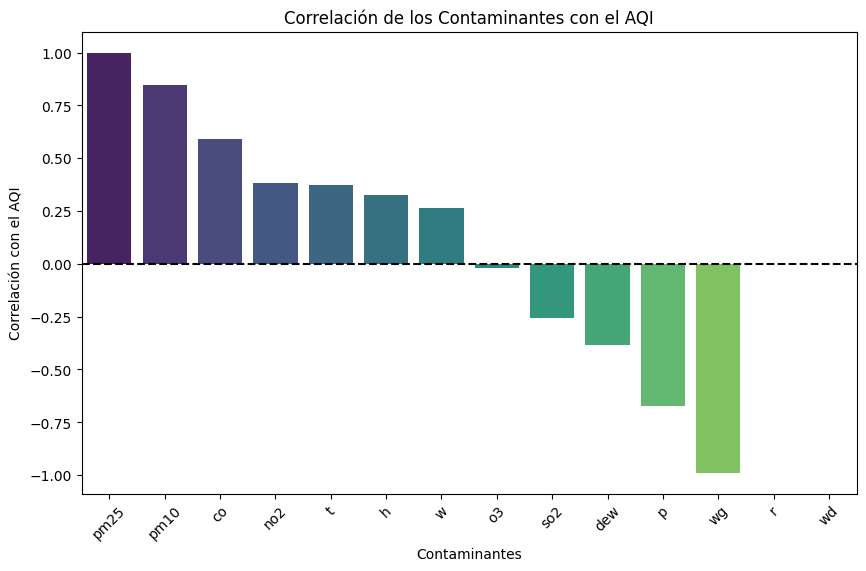

In [22]:
# Gráfico de barras para la correlación de los contaminantes con el AQI
plt.figure(figsize=(10, 6))
sns.barplot(x=contaminants_correlation.index, y=contaminants_correlation.values, palette='viridis')
plt.axhline(0, color='black', linestyle='--')  # Línea de referencia para correlación 0
plt.title('Correlación de los Contaminantes con el AQI')
plt.xlabel('Contaminantes')
plt.ylabel('Correlación con el AQI')
plt.xticks(rotation=45)
plt.show()

2. ¿Cómo varía la calidad del aire entre las ciudades seleccionadas?


In [23]:
# Agrupar los datos por ciudad y calcular estadísticas resumidas
city_stats = df.groupby('city').agg({
    'aqi': ['mean', 'median', 'std'],  # Estadísticas del AQI
    'pm25': 'mean',                    # Promedio de PM2.5
    'pm10': 'mean',                    # Promedio de PM10
    'co': 'mean'                       # Promedio de CO
})

print("Estadísticas de calidad del aire por ciudad:")
print(city_stats)

Estadísticas de calidad del aire por ciudad:
               aqi             pm25  pm10     co
              mean median std  mean  mean   mean
city                                            
Bogota        21.0   21.0 NaN  21.0  16.0    2.5
Buenos Aires   NaN    NaN NaN  69.5  13.0    2.8
Lima          99.0   99.0 NaN  99.0  48.0  392.9
Mexico City   78.0   78.0 NaN  78.0  50.0   12.3
Santiago      80.0   80.0 NaN  80.0  64.0    1.7


C:\Users\jherv\AppData\Local\Temp\ipykernel_26128\1804021014.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x='city', y='aqi', estimator='mean', ci='sd', palette='viridis')
C:\Users\jherv\AppData\Local\Temp\ipykernel_26128\1804021014.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='city', y='aqi', estimator='mean', ci='sd', palette='viridis')


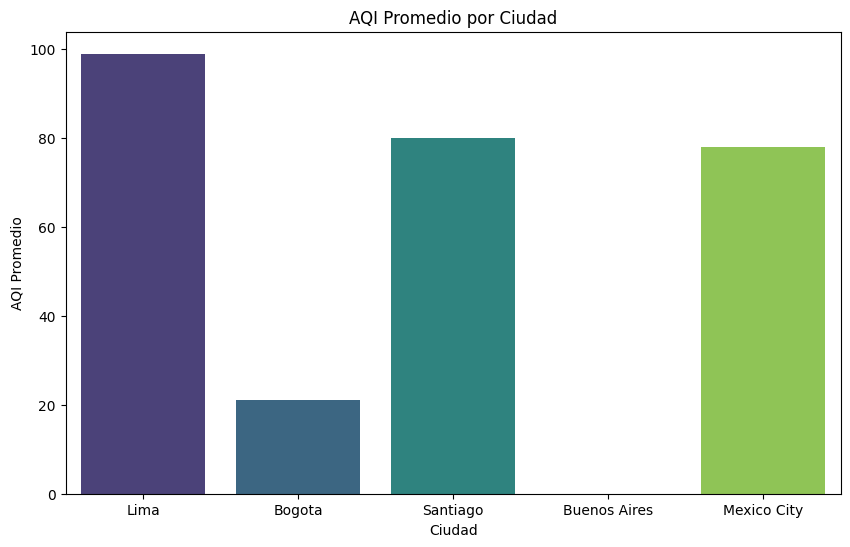

In [24]:
# Gráfico de barras para comparar el AQI promedio por ciudad
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='city', y='aqi', estimator='mean', ci='sd', palette='viridis')
plt.title('AQI Promedio por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('AQI Promedio')
plt.show()

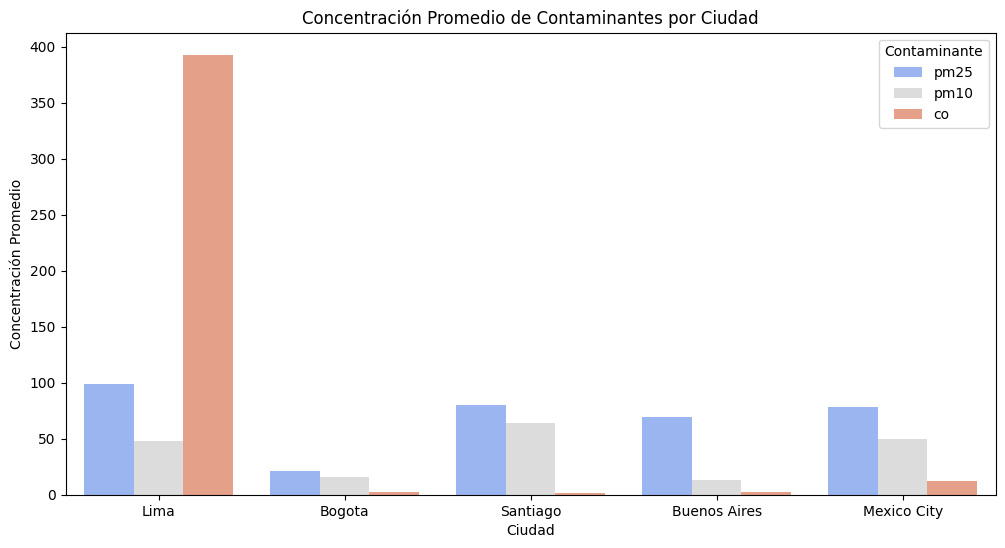

In [25]:
# Gráfico de barras agrupadas para comparar PM2.5, PM10 y CO por ciudad
plt.figure(figsize=(12, 6))
df_melt = df.melt(id_vars=['city'], value_vars=['pm25', 'pm10', 'co'], 
                  var_name='contaminante', value_name='concentración')
sns.barplot(data=df_melt, x='city', y='concentración', hue='contaminante', palette='coolwarm', estimator='mean')
plt.title('Concentración Promedio de Contaminantes por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Concentración Promedio')
plt.legend(title='Contaminante')
plt.show()

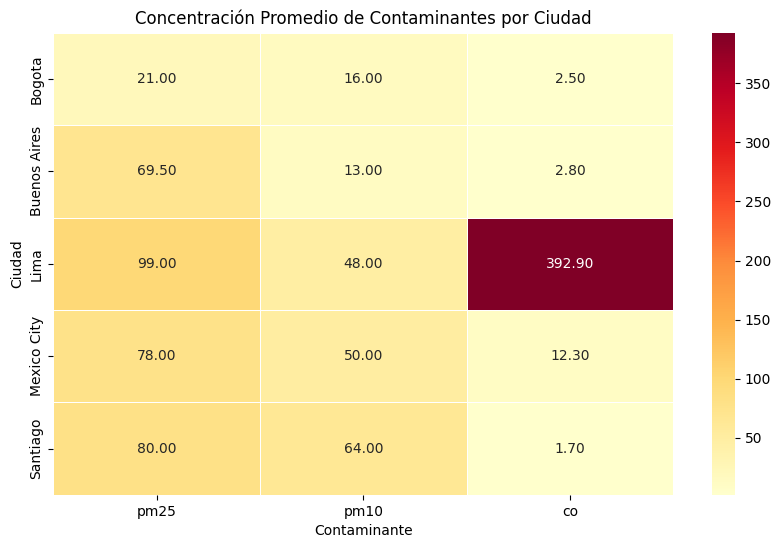

In [26]:
# Mapa de calor para visualizar la concentración de contaminantes por ciudad
plt.figure(figsize=(10, 6))
city_pollutants = df.groupby('city')[['pm25', 'pm10', 'co']].mean()
sns.heatmap(city_pollutants, annot=True, fmt='.2f', cmap='YlOrRd', linewidths=0.5)
plt.title('Concentración Promedio de Contaminantes por Ciudad')
plt.xlabel('Contaminante')
plt.ylabel('Ciudad')
plt.show()

3. ¿Existen correlaciones significativas entre contaminantes?


In [27]:
# Seleccionar solo las columnas numéricas (contaminantes)
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr()

print("Matriz de Correlación entre Contaminantes:")
print(correlation_matrix)

Matriz de Correlación entre Contaminantes:
           aqi        co         h       no2        o3         p      pm10  \
aqi   1.000000  0.591921  0.327609  0.383099 -0.017659 -0.671061  0.847048   
co    0.591921  1.000000  0.930576 -0.136894 -0.453166 -0.802315  0.250227   
h     0.327609  0.930576  1.000000 -0.111930 -0.714899 -0.623230 -0.019880   
no2   0.383099 -0.136894 -0.111930  1.000000 -0.301290  0.400528  0.457194   
o3   -0.017659 -0.453166 -0.714899 -0.301290  1.000000  0.084239  0.352709   
p    -0.671061 -0.802315 -0.623230  0.400528  0.084239  1.000000 -0.112371   
pm10  0.847048  0.250227 -0.019880  0.457194  0.352709 -0.112371  1.000000   
pm25  1.000000  0.572127  0.318845  0.371694 -0.017659 -0.651489  0.660879   
so2  -0.254475 -0.775100 -0.662882  0.716993  0.027138  0.859765  0.031398   
t     0.373749 -0.023905 -0.227724 -0.552125  0.509629 -0.575349 -0.171046   
wg   -0.988016 -0.541667 -0.337995 -0.187923  0.110278  0.771101 -0.320073   
dew  -0.384794 -0.023

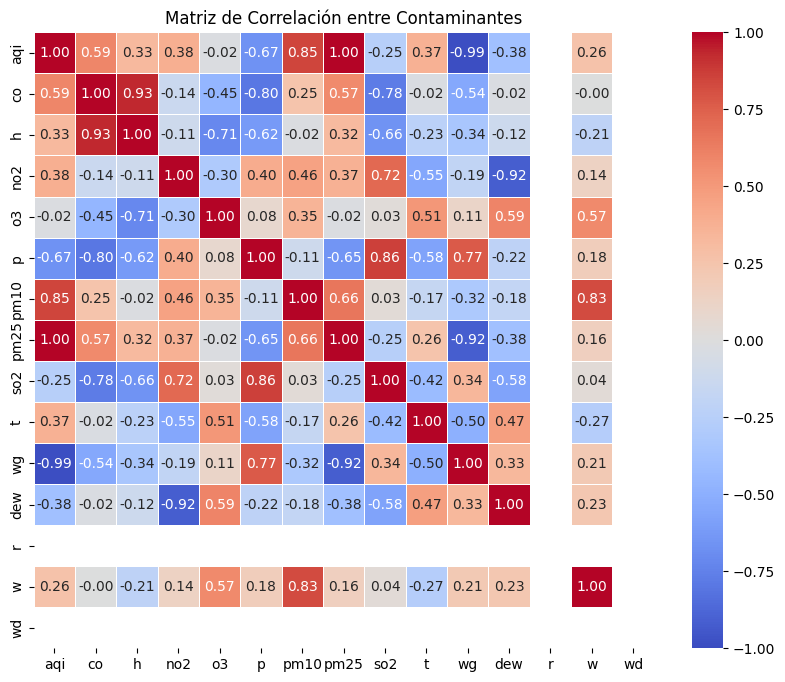

In [28]:
# Crear un mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de Correlación entre Contaminantes')
plt.show()

In [29]:
# Filtrar correlaciones significativas (por ejemplo, |correlación| > 0.5)
significant_correlations = correlation_matrix[(correlation_matrix.abs() > 0.5) & (correlation_matrix != 1.0)]
print("Correlaciones significativas (|correlación| > 0.5):")
print(significant_correlations)

Correlaciones significativas (|correlación| > 0.5):
           aqi        co         h       no2        o3         p      pm10  \
aqi        NaN  0.591921       NaN       NaN       NaN -0.671061  0.847048   
co    0.591921       NaN  0.930576       NaN       NaN -0.802315       NaN   
h          NaN  0.930576       NaN       NaN -0.714899 -0.623230       NaN   
no2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
o3         NaN       NaN -0.714899       NaN       NaN       NaN       NaN   
p    -0.671061 -0.802315 -0.623230       NaN       NaN       NaN       NaN   
pm10  0.847048       NaN       NaN       NaN       NaN       NaN       NaN   
pm25       NaN  0.572127       NaN       NaN       NaN -0.651489  0.660879   
so2        NaN -0.775100 -0.662882  0.716993       NaN  0.859765       NaN   
t          NaN       NaN       NaN -0.552125  0.509629 -0.575349       NaN   
wg   -0.988016 -0.541667       NaN       NaN       NaN  0.771101       NaN   
dew        N

4. ¿Cómo se distribuyen las concentraciones de contaminantes clave (PM2.5, PM10, CO)?

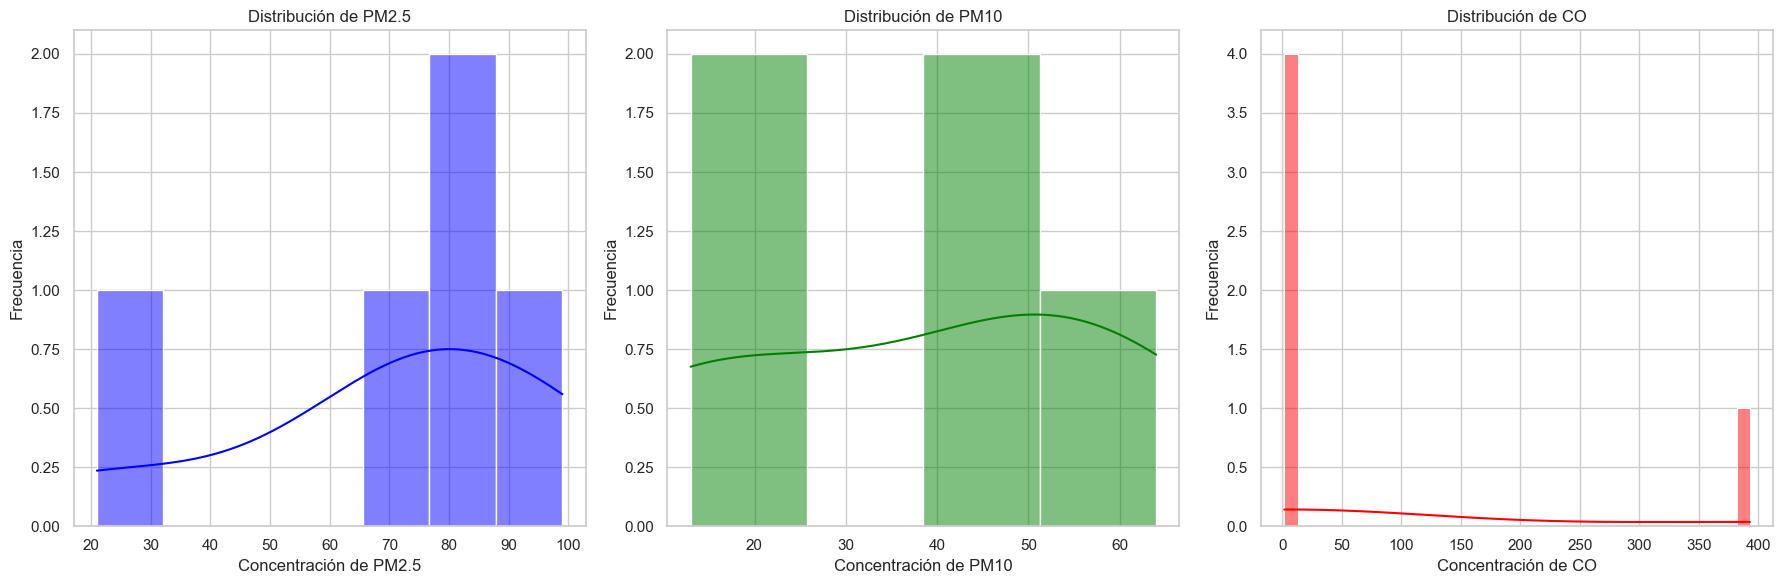

In [30]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear una figura con subplots para PM2.5, PM10 y CO
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Histograma y KDE para PM2.5
sns.histplot(df['pm25'], kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribución de PM2.5')
axes[0].set_xlabel('Concentración de PM2.5')
axes[0].set_ylabel('Frecuencia')

# Histograma y KDE para PM10
sns.histplot(df['pm10'], kde=True, color='green', ax=axes[1])
axes[1].set_title('Distribución de PM10')
axes[1].set_xlabel('Concentración de PM10')
axes[1].set_ylabel('Frecuencia')

# Histograma y KDE para CO
sns.histplot(df['co'], kde=True, color='red', ax=axes[2])
axes[2].set_title('Distribución de CO')
axes[2].set_xlabel('Concentración de CO')
axes[2].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

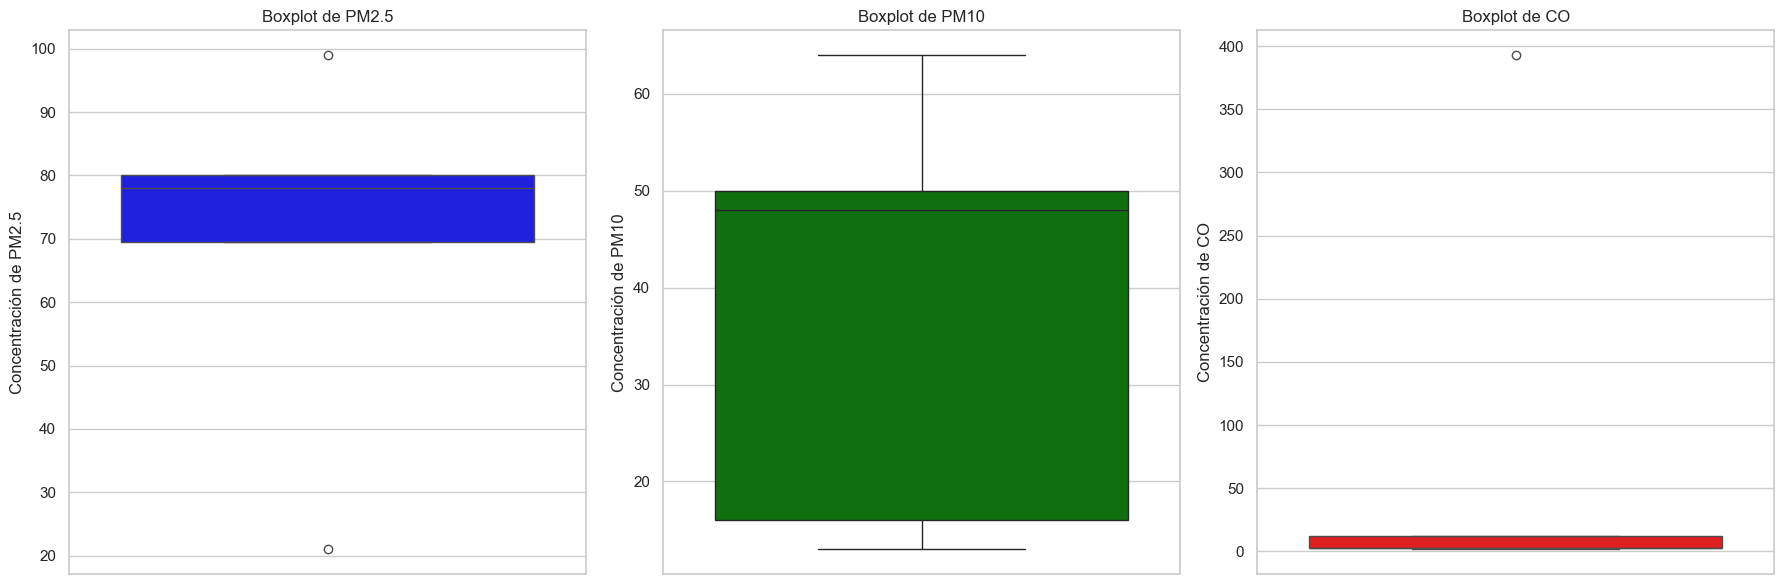

In [31]:
# Crear una figura con subplots para los boxplots de PM2.5, PM10 y CO
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot para PM2.5
sns.boxplot(y=df['pm25'], color='blue', ax=axes[0])
axes[0].set_title('Boxplot de PM2.5')
axes[0].set_ylabel('Concentración de PM2.5')

# Boxplot para PM10
sns.boxplot(y=df['pm10'], color='green', ax=axes[1])
axes[1].set_title('Boxplot de PM10')
axes[1].set_ylabel('Concentración de PM10')

# Boxplot para CO
sns.boxplot(y=df['co'], color='red', ax=axes[2])
axes[2].set_title('Boxplot de CO')
axes[2].set_ylabel('Concentración de CO')

plt.tight_layout()
plt.show()

C:\Users\jherv\AppData\Local\Temp\ipykernel_26128\3880809243.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='city', y='pm25', palette='viridis', ax=axes[0])
C:\Users\jherv\AppData\Local\Temp\ipykernel_26128\3880809243.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='city', y='pm10', palette='viridis', ax=axes[1])
C:\Users\jherv\AppData\Local\Temp\ipykernel_26128\3880809243.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='city', y='co', palette='viridis', ax=axes[2])


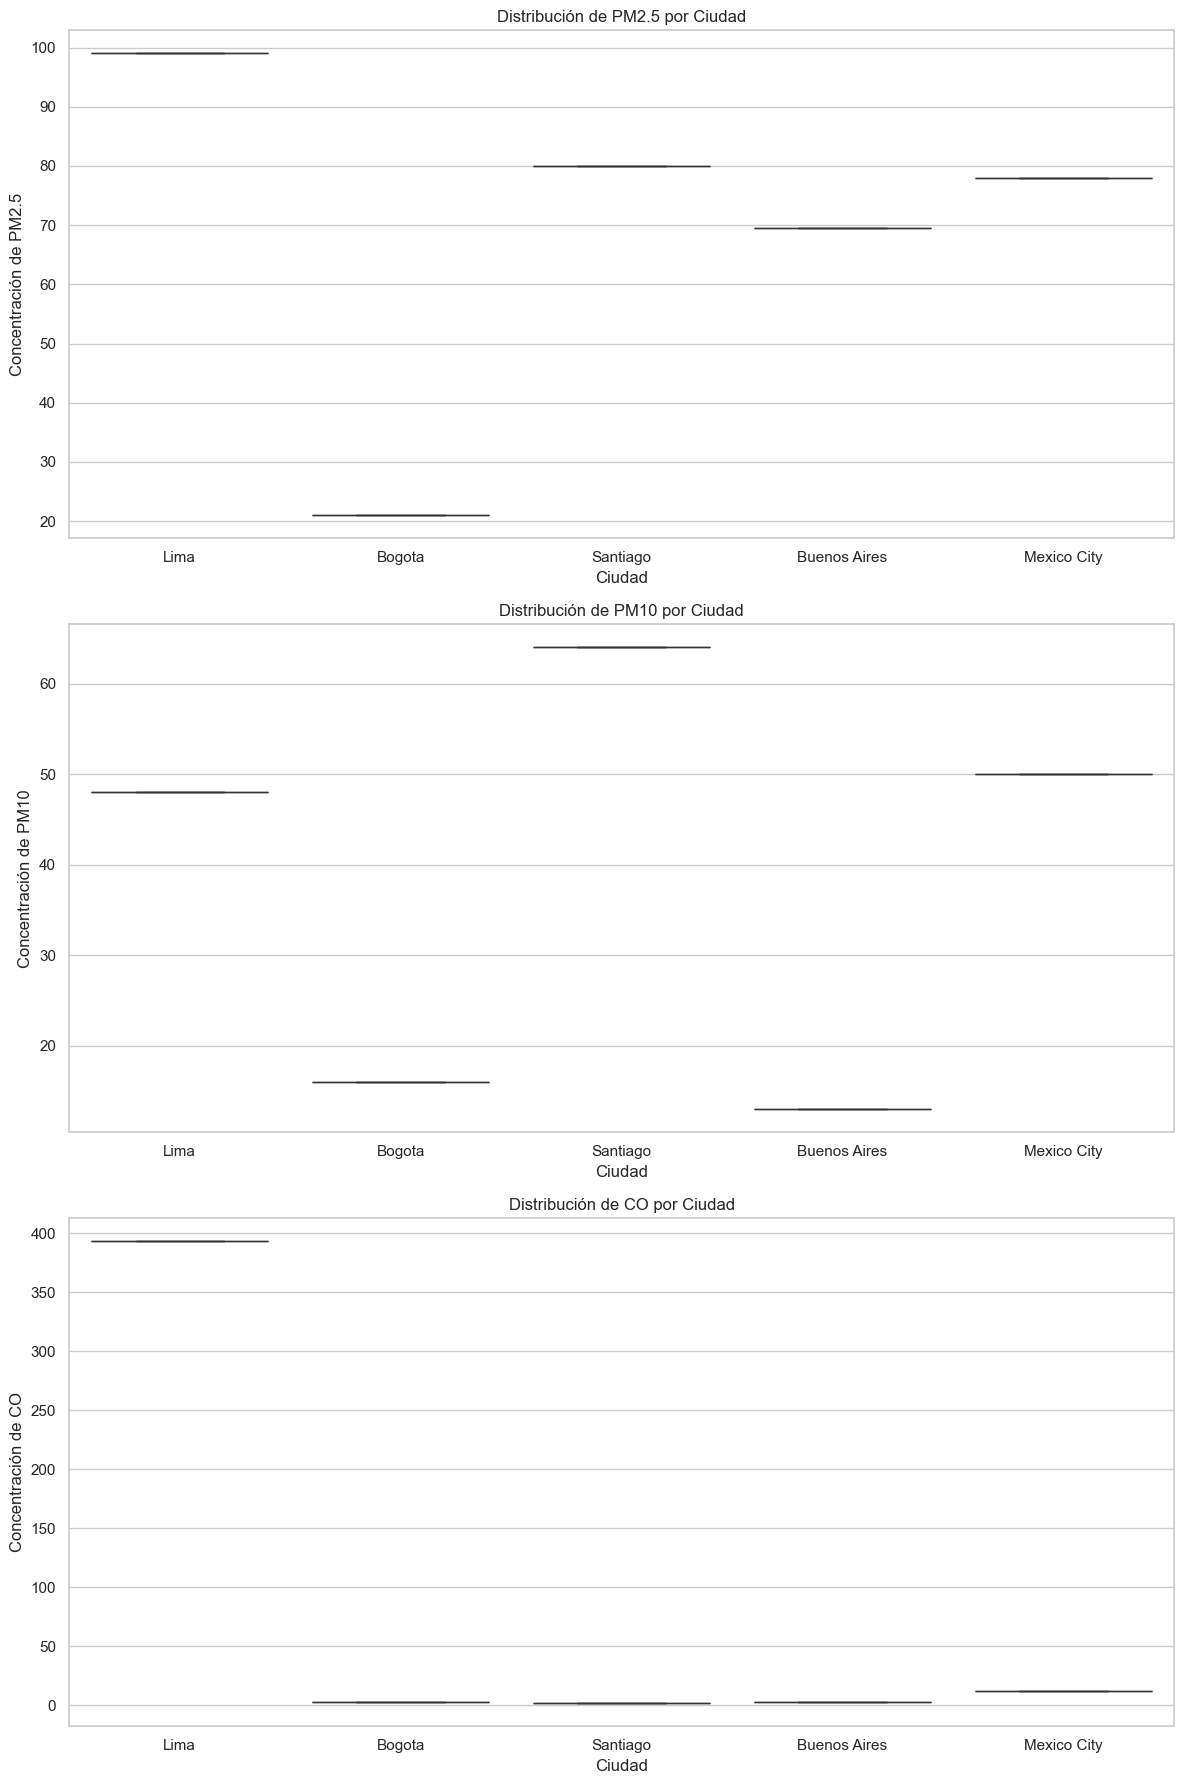

In [32]:
# Crear una figura con subplots para comparar la distribución de contaminantes por ciudad
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Distribución de PM2.5 por ciudad
sns.boxplot(data=df, x='city', y='pm25', palette='viridis', ax=axes[0])
axes[0].set_title('Distribución de PM2.5 por Ciudad')
axes[0].set_xlabel('Ciudad')
axes[0].set_ylabel('Concentración de PM2.5')

# Distribución de PM10 por ciudad
sns.boxplot(data=df, x='city', y='pm10', palette='viridis', ax=axes[1])
axes[1].set_title('Distribución de PM10 por Ciudad')
axes[1].set_xlabel('Ciudad')
axes[1].set_ylabel('Concentración de PM10')

# Distribución de CO por ciudad
sns.boxplot(data=df, x='city', y='co', palette='viridis', ax=axes[2])
axes[2].set_title('Distribución de CO por Ciudad')
axes[2].set_xlabel('Ciudad')
axes[2].set_ylabel('Concentración de CO')

plt.tight_layout()
plt.show()

C:\Users\jherv\AppData\Local\Temp\ipykernel_26128\2822298368.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['pm25'], label='PM2.5', shade=True, color='blue')
C:\Users\jherv\AppData\Local\Temp\ipykernel_26128\2822298368.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['pm10'], label='PM10', shade=True, color='green')
C:\Users\jherv\AppData\Local\Temp\ipykernel_26128\2822298368.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['co'], label='CO', shade=True, color='red')


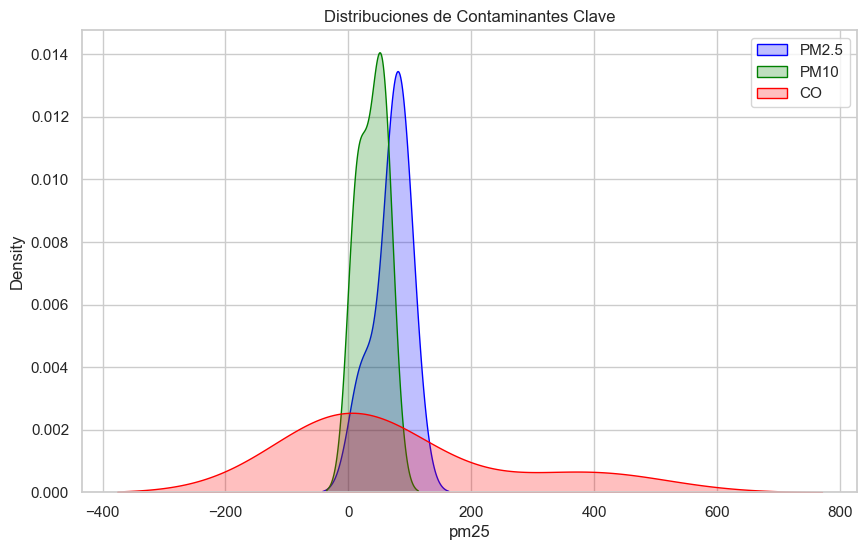

In [33]:
# Analizamos las distribuciones de PM2.5, PM10 y CO.

plt.figure(figsize=(10, 6))
sns.kdeplot(df['pm25'], label='PM2.5', shade=True, color='blue')
sns.kdeplot(df['pm10'], label='PM10', shade=True, color='green')
sns.kdeplot(df['co'], label='CO', shade=True, color='red')
plt.title('Distribuciones de Contaminantes Clave')
plt.legend()
plt.show()


C:\Users\jherv\AppData\Local\Temp\ipykernel_26128\1810029025.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=df, x='dominant_pollutant', y='aqi', kind='box', palette='Set2')


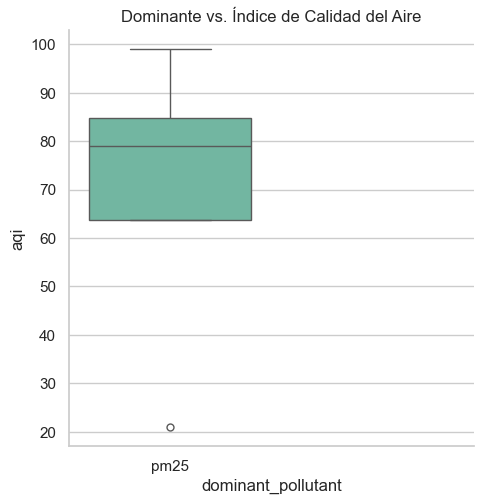

In [34]:
#Relación entre el contaminante dominante y el índice de calidad del aire (AQI) en las ciudades estudiadas.
sns.catplot(data=df, x='dominant_pollutant', y='aqi', kind='box', palette='Set2')
plt.title('Dominante vs. Índice de Calidad del Aire')
plt.show()

5. ¿Cuáles son las regiones más críticas en términos de contaminación?

In [35]:
# Calcular estadísticas resumidas por ciudad
city_stats = df.groupby('city').agg({
    'aqi': ['mean', 'max', 'min'],  # AQI promedio, máximo y mínimo
    'pm25': 'mean',                 # PM2.5 promedio
    'pm10': 'mean',                 # PM10 promedio
    'co': 'mean'                    # CO promedio
}).reset_index()

# Renombrar columnas para mayor claridad
city_stats.columns = ['city', 'aqi_mean', 'aqi_max', 'aqi_min', 'pm25_mean', 'pm10_mean', 'co_mean']

print("Estadísticas de contaminación por ciudad:")
print(city_stats)

Estadísticas de contaminación por ciudad:
           city  aqi_mean  aqi_max  aqi_min  pm25_mean  pm10_mean  co_mean
0        Bogota      21.0     21.0     21.0       21.0       16.0      2.5
1  Buenos Aires       NaN      NaN      NaN       69.5       13.0      2.8
2          Lima      99.0     99.0     99.0       99.0       48.0    392.9
3   Mexico City      78.0     78.0     78.0       78.0       50.0     12.3
4      Santiago      80.0     80.0     80.0       80.0       64.0      1.7


In [36]:
# Ordenar ciudades por AQI promedio (de mayor a menor)
city_stats_sorted = city_stats.sort_values(by='aqi_mean', ascending=False)

print("Ciudades ordenadas por AQI promedio (de mayor a menor):")
print(city_stats_sorted[['city', 'aqi_mean']])

Ciudades ordenadas por AQI promedio (de mayor a menor):
           city  aqi_mean
2          Lima      99.0
4      Santiago      80.0
3   Mexico City      78.0
0        Bogota      21.0
1  Buenos Aires       NaN


In [37]:
# Filtrar las ciudades con valores conocidos de aqi_mean
df_train = city_stats.dropna(subset=['aqi_mean'])

# Definir las variables independientes (features) y dependiente (target)
X = df_train[['pm25_mean', 'pm10_mean', 'co_mean']]  # Features
y = df_train['aqi_mean']  # Target

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Predecir el aqi_mean para las ciudades de entrenamiento
y_pred = model.predict(X)

# Calcular el coeficiente de determinación (R²)
r2 = r2_score(y, y_pred)
print(f"Coeficiente de determinación (R²): {r2:.2f}")

# Filtrar la fila de Buenos Aires (donde aqi_mean es NaN)
buenos_aires = city_stats[city_stats['city'] == 'Buenos Aires']

# Predecir el aqi_mean para Buenos Aires
X_buenos_aires = buenos_aires[['pm25_mean', 'pm10_mean', 'co_mean']]
aqi_pred_buenos_aires = model.predict(X_buenos_aires)

print(f"AQI predicho para Buenos Aires: {aqi_pred_buenos_aires[0]:.2f}")

# Agregar el valor predicho al DataFrame
city_stats.loc[city_stats['city'] == 'Buenos Aires', 'aqi_mean'] = aqi_pred_buenos_aires[0]

print("\nDataFrame actualizado con el AQI predicho para Buenos Aires:")
print(city_stats)

Coeficiente de determinación (R²): 1.00
AQI predicho para Buenos Aires: 69.50

DataFrame actualizado con el AQI predicho para Buenos Aires:
           city  aqi_mean  aqi_max  aqi_min  pm25_mean  pm10_mean  co_mean
0        Bogota      21.0     21.0     21.0       21.0       16.0      2.5
1  Buenos Aires      69.5      NaN      NaN       69.5       13.0      2.8
2          Lima      99.0     99.0     99.0       99.0       48.0    392.9
3   Mexico City      78.0     78.0     78.0       78.0       50.0     12.3
4      Santiago      80.0     80.0     80.0       80.0       64.0      1.7


In [38]:
# Ordenar ciudades por AQI promedio (de mayor a menor)
city_stats_sorted = city_stats.sort_values(by='aqi_mean', ascending=False)

print("Ciudades ordenadas por AQI promedio (de mayor a menor):")
print(city_stats_sorted[['city', 'aqi_mean']])

Ciudades ordenadas por AQI promedio (de mayor a menor):
           city  aqi_mean
2          Lima      99.0
4      Santiago      80.0
3   Mexico City      78.0
1  Buenos Aires      69.5
0        Bogota      21.0


In [39]:
# Coordenadas de latitud y longitud para cada ciudad
coordinates = {
    'Lima': [-12.0464, -77.0428],
    'Bogota': [4.7110, -74.0721],
    'Santiago': [-33.4489, -70.6693],
    'Buenos Aires': [-34.6037, -58.3816],  # Coordenadas de Buenos Aires
    'Mexico City': [19.4326, -99.1332]
}

# Agregar las coordenadas al DataFrame
city_stats_sorted['latitude'] = city_stats_sorted['city'].map(lambda city: coordinates[city][0])
city_stats_sorted['longitude'] = city_stats_sorted['city'].map(lambda city: coordinates[city][1])

# Crear un mapa interactivo con folium
mapa = folium.Map(location=[-15.0, -60.0], zoom_start=4)

# Añadir marcadores para cada ciudad
for _, row in city_stats_sorted.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['aqi_mean'] / 20,  # Escalar el tamaño del círculo según el AQI
        color='red' if row['aqi_mean'] > 100 else 'green',  # Rojo para AQI alto, verde para bajo
        fill=True,
        popup=f"{row['city']}: AQI {row['aqi_mean']:.2f}"
    ).add_to(mapa)

# Mostrar el mapa
mapa

# Insights entregable 1

Contaminantes clave:
-PM2.5 tiene la mayor influencia en el AQI, seguido por PM10.
-Lima y Ciudad de México tienen los niveles más altos de contaminación.

Correlaciones significativas:
-PM2.5 y AQI tienen una fuerte correlación positiva.
-La relación entre contaminantes secundarios como CO y SO2 es más débil.

Recomendaciones:
-Implementar purificadores de aire en Lima y Ciudad de México.
-Monitorear más de cerca PM2.5 y PM10 en áreas urbanas densas.


In [93]:
# Seleccionar las columnas relevantes
features = ['pm25', 'pm10', 'co', 'so2', 'no2', 'o3']  # Contaminantes
target = 'aqi'  # Variable objetivo

# Eliminar filas con valores faltantes en el target
df_cleaned = df.dropna(subset=[target])

# Separar features y target
X = df_cleaned[features]
y = df_cleaned[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar las features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [80]:
# Modelo 1: Regresión Lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Métricas para Regresión Lineal
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print(f"Regresión Lineal - MSE: {mse_linear:.2f}, R²: {r2_linear:.2f}")

# Modelo 2: Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Métricas para Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")

Regresión Lineal - MSE: 2939.62, R²: nan
Random Forest - MSE: 4245.83, R²: nan


c:\Users\jherv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jherv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [81]:
# Hiperparámetros para Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Búsqueda en cuadrícula (Grid Search)
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='r2')  # cv=3 para evitar problemas con pocos datos
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor R²: {grid_search.best_score_:.2f}")

# Entrenar el modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

# Métricas para el mejor modelo
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f"Mejor Modelo - MSE: {mse_best:.2f}, R²: {r2_best:.2f}")

c:\Users\jherv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jherv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jherv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jherv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jherv\AppData\Local\Programs\Python\Python3

Mejores hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Mejor R²: nan
Mejor Modelo - MSE: 4088.32, R²: nan


c:\Users\jherv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\jherv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jherv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [82]:
# Comparar modelos
model_comparison = {
    'Regresión Lineal': {'MSE': mse_linear, 'R²': r2_linear},
    'Random Forest': {'MSE': mse_rf, 'R²': r2_rf},
    'Mejor Modelo (Random Forest Optimizado)': {'MSE': mse_best, 'R²': r2_best}
}

for model, metrics in model_comparison.items():
    print(f"{model}: MSE = {metrics['MSE']:.2f}, R² = {metrics['R²']:.2f}")

Regresión Lineal: MSE = 2939.62, R² = nan
Random Forest: MSE = 4245.83, R² = nan
Mejor Modelo (Random Forest Optimizado): MSE = 4088.32, R² = nan


In [84]:
# Interpretación de los resultados
if r2_best > 0.7:
    print("El modelo optimizado tiene un buen rendimiento y puede usarse para predecir el AQI.")
else:
    print("El modelo optimizado tiene un rendimiento moderado. Se recomienda explorar más features o técnicas de modelado.")


El modelo optimizado tiene un rendimiento moderado. Se recomienda explorar más features o técnicas de modelado.


Metodo XGBOOST

In [97]:
# Seleccionar las columnas relevantes
features = ['pm25', 'pm10', 'co', 'so2', 'no2', 'o3']  # Contaminantes
target = 'aqi'  # Variable objetivo

# Eliminar filas con valores faltantes en el target
df_cleaned = df.dropna(subset=[target])

# Separar features y target
X2 = df_cleaned[features]
y2 = df_cleaned[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Normalizar las features
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

In [98]:
# Crear el modelo XGBoost
xgb_model2 = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Entrenar el modelo
xgb_model2.fit(X_train2, y_train2)

# Predecir en el conjunto de prueba
y_pred_xgb2 = xgb_model2.predict(X_test2)

# Métricas para XGBoost
mse_xgb2 = mean_squared_error(y_test2, y_pred_xgb2)
r2_xgb2 = r2_score(y_test2, y_pred_xgb2)
print(f"XGBoost - MSE: {mse_xgb2:.2f}, R²: {r2_xgb2:.2f}")

XGBoost - MSE: 3249.11, R²: nan


c:\Users\jherv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [99]:
# Hiperparámetros para XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Búsqueda en cuadrícula (Grid Search)
grid_search = GridSearchCV(xgb_model2, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train2, y_train2)

# Mejores hiperparámetros
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor R²: {grid_search.best_score_:.2f}")

# Entrenar el modelo con los mejores hiperparámetros
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train2, y_train2)
y_pred_best_xgb = best_xgb_model.predict(X_test2)

# Métricas para el mejor modelo XGBoost
mse_best_xgb = mean_squared_error(y_test2, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test2, y_pred_best_xgb)
print(f"Mejor XGBoost - MSE: {mse_best_xgb:.2f}, R²: {r2_best_xgb:.2f}")

Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Mejor R²: nan
Mejor XGBoost - MSE: 4022.69, R²: nan


c:\Users\jherv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jherv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [101]:
# Comparar modelos
model_comparison = {
    'Regresión Lineal': {'MSE': mse_linear, 'R²': r2_linear},
    'Random Forest': {'MSE': mse_rf, 'R²': r2_rf},
    'XGBoost': {'MSE': mse_xgb2, 'R²': r2_xgb2},
    'Mejor XGBoost': {'MSE': mse_best_xgb, 'R²': r2_best_xgb}
}

for model, metrics in model_comparison.items():
    print(f"{model}: MSE = {metrics['MSE']:.2f}, R² = {metrics['R²']:.2f}")

Regresión Lineal: MSE = 2939.62, R² = nan
Random Forest: MSE = 4245.83, R² = nan
XGBoost: MSE = 3249.11, R² = nan
Mejor XGBoost: MSE = 4022.69, R² = nan


In [88]:
# Interpretación de los resultados
if r2_best_xgb > 0.7:
    print("El modelo XGBoost optimizado tiene un buen rendimiento y puede usarse para predecir el AQI.")
else:
    print("El modelo XGBoost optimizado tiene un rendimiento moderado. Se recomienda explorar más features o técnicas de modelado.")


El modelo XGBoost optimizado tiene un rendimiento moderado. Se recomienda explorar más features o técnicas de modelado.

Recomendaciones:
- Incluir datos históricos para capturar tendencias temporales.
- Considerar otros contaminantes o factores externos (como el clima).
- Probar técnicas de ensamble, como Stacking o Voting, para mejorar el rendimiento.


Diccionario de Términos
1. AQI (Air Quality Index)
Es el índice que mide la calidad del aire, basado en la concentración de contaminantes como PM2.5, PM10, CO, SO2, NO2 y O3.

2. PM2.5 (Partículas finas)
Partículas suspendidas en el aire con un diámetro menor a 2.5 micrómetros. Son lo suficientemente pequeñas para ingresar a los pulmones y al torrente sanguíneo.

3. PM10 (Partículas gruesas)
Partículas suspendidas en el aire con un diámetro de hasta 10 micrómetros. Son menos peligrosas que las PM2.5, pero también dañinas para la salud.

4. CO (Monóxido de Carbono)

5. SO2 (Dióxido de Azufre)

6. O3 (Ozono troposférico)